In [1]:
import numpy as np
from matplotlib import pyplot as plt
PI = np.pi

In [2]:
def calculate_magnetic_field(IA: float, IB: float):
    """
    Calculates the magnetic field generated when energizing the two phases of the motor.

    This function assumes a that we are working with a bipolar stepper motor with two phases.
    Each phase has four windings around four poles, positioned around the stator as follows:
       Phase A poles: A1 @ 0   , A2 @ 1/2π, A3 @ π   , A4 @ 3/2π 
       Phase B poles: B1 @ 1/4π, B2 @ 3/4π, B3 @ 5/4π, B4 @ 7/4π

    The windings around the poles are such that passing an electric current through the phase 
    generates alternating magnetic polarities:
       Positive current through Phase A:  A1 - Nord , A2 - South, A3 - Nord , A4 - South
       Negative current through Phase A:  A1 - South, A2 - Nord , A3 - South, A4 - Nord
       Positive current through Phase B:  B1 - Nord , B2 - South, B3 - Nord , B4 - South
       Negative current through Phase B:  B1 - South, B2 - Nord , B3 - South, B4 - Nord

    We define the reference magnetic configuration as the magnetic field produced by the stator
    when the poles are oriented as described above and max positive current is flowing through 
    Phase A, while no current is flowing through Phase B. 

    The function inputs are the signed intensities of the electric current through Phase A & B.
    The current magnitude is normalized to 1.

    The output is expressed as the magnitude of the magnetic field generated by the stator and
    the angle at which this field is rotated relative to the reference magnetic configuration.
    The magnetic field magnitude is normalized to 1 (which is defined to be the magnitude of the
    reference configuration field).
    The rotation angle is mapped to [0, π), since the magnetic field produced by the stator is 
    invariant to rotations by an angle of N * π.
    
    Parameters:
        IA - signed intensity of the electric current through Phase A
        IA - signed intensity of the electric current through Phase B

    Returns: a tuple
        normalized magnitude of the magnetic field produced by the stator
        angle of rotation of the magnetic field produced by the stator
    """
    if IA == 0.0 and IB == 0.0:
        return 0.0, 0.0

    # The angle of rotation is measured clockwise, relative to the vertical,
    # therefore the [0, π) range encompases the left semi-circle. We divide
    # this semi-circle into 4 equal sectors:
    #   Sector 1: [0   , 1/4π)
    #   Sector 2: [1/4π, 1/2π)
    #   Sector 3: [1/2π, 3/4π)
    #   Sector 4: [3/4π, π)
    # The sector boundaries are the positions of the stator poles (see docstring)

    # Consider the following:
    # - start with IA = 1 and IB = 0 => the field is in the reference configuration.
    # - decrease IA and increase IB  => the field rotates to the right
    # - while both IA > 0 and IB > 0 the angle of rotation is less than 45°
    # We deduce that IA > 0 & IB >= 0 => the field rotation angle is in sector 1.
    # Below we map current direction to sector, for all possible combinations:
    
    is_sector1 = IA >  0.0 and IB >= 0.0  
    is_sector2 = IA <= 0.0 and IB >  0.0  
    is_sector3 = IA <  0.0 and IB <= 0.0  
    is_sector4 = IA >= 0.0 and IB <  0.0  

    # Since we've constrained the angle of rotation to a sector, we reduced the problem
    # of calculating it to that of locating the angle within the sector. For this, the
    # direction of the current is not relevant anymore, only its absolute intensity.
    IA = abs(IA)
    IB = abs(IB)

    # For each sector, we consider the directions that are the boundaries of that sector.
    # This direction connects poles that belong to the same phase and have the same polarization.
    # For example: sector 1 is bound the the A1-A3 and B1-B3 lines respectively.
    # The current intensity IA and IB controls the magnitude of the two magnetic fields relative
    # to these two directions; the resulting field is their superposition (sum).
    # In what follows, we want to write the vectors that define these 2 fields and add them up.
    
    # Express the two magnetic fields (that we directly generate) in cartesian coordinates.
    # NOTE: We assume that the magnitude of the magnetic field is proportional with the current 
    #       intensity and we set the proportionality constant to 1. 
    c = np.sqrt(2)/2    
    if is_sector1:
        B1 = [0   ,   IA]    # along the A1-A3 direction (vertical)
        B2 = [c*IB, c*IB]    # along the B1-B3 direction (45°)
    elif is_sector2:
        B1 = [c*IB, c*IB]    # along the B1-B3 direction (45°)
        B2 = [IA  ,    0]    # along the A2-A4 direction (horizontal)
    elif is_sector3:
        B1 = [IA  ,     0]   # along the A2-A4 direction (horizontal)
        B2 = [c*IB, -c*IB]   # along the B2-B4 direction (135°)
    else:
        B1 = [c*IB, -c*IB]   # along the B2-B4 direction (135°)
        B2 = [0   ,   -IA]   # along the A1-A3 direction (vertical)

    # Add up the two vectors by adding their cartesian coordinates
    Bx = B1[0] + B2[0]
    By = B1[1] + B2[1]
    
    # Calculate magnitude of the vector sum
    magnitude = np.sqrt(Bx**2 + By**2)
    
    # Calculate angle relative to positive x-axis (horizontal)
    angle_from_horizontal = np.arctan2(By, Bx)  # range: [-π, π]
        
    # Transform to angle from vertical (clockwise positive)
    # Also convert from [-π, π] to [0, 2π]
    angle = np.pi/2 - angle_from_horizontal
    if angle < 0:
        angle += 2 * np.pi
    
    return magnitude, angle

In [3]:
def standard_control(theta: float):
    """
    Calculates the current intensity that rotates the stator magnetic field by a given angle.
    Uses a simple sin-cos formula.
    """
    return np.cos(2*theta), np.sin(2*theta)

def advanced_control(theta: float):
    """
    Calculates the current intensity that rotates the stator magnetic field by a given angle.
    
    This function assumes a that we are working with a bipolar stepper motor with two phases.
    Each phase has four windings around four poles, positioned around the stator as follows:
       Phase A poles: A1 @ 0   , A2 @ 1/2π, A3 @ π   , A4 @ 3/2π 
       Phase B poles: B1 @ 1/4π, B2 @ 3/4π, B3 @ 5/4π, B4 @ 7/4π

    The windings around the poles are such that passing an electric current through the phase 
    generates alternating magnetic polarities:
       Positive current through Phase A:  A1 - Nord , A2 - South, A3 - Nord , A4 - South
       Negative current through Phase A:  A1 - South, A2 - Nord , A3 - South, A4 - Nord
       Positive current through Phase B:  B1 - Nord , B2 - South, B3 - Nord , B4 - South
       Negative current through Phase B:  B1 - South, B2 - Nord , B3 - South, B4 - Nord

    We define the reference magnetic configuration as the magnetic field produced by the stator
    when the poles are oriented as described above and max positive current is flowing through 
    Phase A, while no current is flowing through Phase B. By cutting the current through Phase A 
    and passing max positive current through Phase B we rotate the magnetic field clockwise by 45°.

    Imagine having a dial with an arrow, which when pointing upwards corresponds to the stator 
    generating the reference magnetic field. As we turn this dial, the magnetic field generated by
    the stator rotates like the dial's arrow. This function implements the behavior of such a dial.

    The current intensity is a expressed as a number between -1.0 and 1.0, where 1.0 means fully
    energizing the phase in one direction, and -1.0 means fully energizing the phase with the 
    electric current flowing in the opposite direction. Which direction corresponds to +1.0 and
    which direction to -1.0 is both arbitrary and irrelevant.

    Parameters:
        theta - the angle by which to rotate the reference magnetic field (clockwise is positive)
    
    Returns: 
        a tuple: (PhaseA current intensity, PhaseB current intensity)
    """

    # Since the magnetic field produced by the stator is invariant to rotations
    # by an angle of N * π, we map the angle of magnetic rotation to [0, π).
    # Example: rotating the reference field by 195° is the same as rotating it by 15°.
    
    theta = theta % PI

    # The angle of rotation is measured clockwise, relative to the vertical,
    # therefore the [0, π) range encompases the left semi-circle. We divide
    # this semi-circle into 4 equal sectors:
    #   Sector 1: [0   , 1/4π)
    #   Sector 2: [1/4π, 1/2π)
    #   Sector 3: [1/2π, 3/4π)
    #   Sector 4: [3/4π, π)
    # The sector boundaries are the positions of the stator poles (see docstring)
    
    sector_sz = PI/4

    # We map the given angle of rotation to a sector and a relative angle within that sector:
    # Examples:
    #   theta = 15° => sector 1, theta = 15° 
    #   theta = 65° => sector 2, theta = 20°
    #   theta = 90° => sector 3, theta =  0°
    # This reduces the problem of rotating the field by an angle in [0, π) to that of 
    # rotating it by an angle in [0, π/4). This is possible since the symmetry of the
    # stator means that all sectors look the same.

    sector = theta // sector_sz + 1
    theta  = theta - (sector-1) * sector_sz

    # Consider two axes that form a 45° angle, and a unit vector whose direction lies between them.
    # We call an axis the “left axis”  if rotating it 45° clockwise         aligns it with the other given axis.
    # We call an axis the “right axis” if rotating it 45° counter-clockwise aligns it with the other given axis.
    # If 'theta' is the angle between the unit vector and the left axis, then its decomposition along the two
    # axes is:
    #   left  component = np.cos(theta) - np.sin(theta) 
    #   right component = np.sqrt(2) * np.sin(theta)
    #
    # This is the situation we face when decomposing the rotated magnetic field along the direction of the two
    # stator poles that bracket it. This decomposition is useful because we control the intesity of the field 
    # along the direction that connects opposing poles. Setting the field magnitude to 1, its components are: 
    
    B_left  = np.cos(theta) - np.sin(theta)
    B_right = np.sqrt(2) * np.sin(theta)

    # Below we translate magnetic field intensity to current intensity.
    # We assume that the magnitude of the magnetic field is proportional with the current intensity and we 
    # set the proportionality constant to 1. 
    # Also note the sign of the current: generating the same magnetic field along the A1 - A3 vs A2 - A4 
    # direction requires flipping the direction of the current through Phase A (as polarities of poles 
    # A1, A2, A3, A4 alternates).
    
    # left  direction: line connecting poles A1 - A3
    # right direction: line connecting poles B1 - B3        
    if sector == 1:
        Ia = +B_left
        Ib = +B_right

    # left  direction: line connecting poles B1 - B3            
    # right direction: line connecting poles A2 - A4
    elif sector == 2:
        Ia = -B_right 
        Ib = +B_left

    # left  direction: line connecting poles A2 - A4
    # right direction: line connecting poles B2 - B4            
    elif sector == 3:
        Ia = -B_left
        Ib = -B_right

    # left  direction: line connecting poles B2 - B4            
    # right direction: line connecting poles A1 - A3
    elif sector == 4:
        Ia = +B_right
        Ib = -B_left

    return Ia, Ib

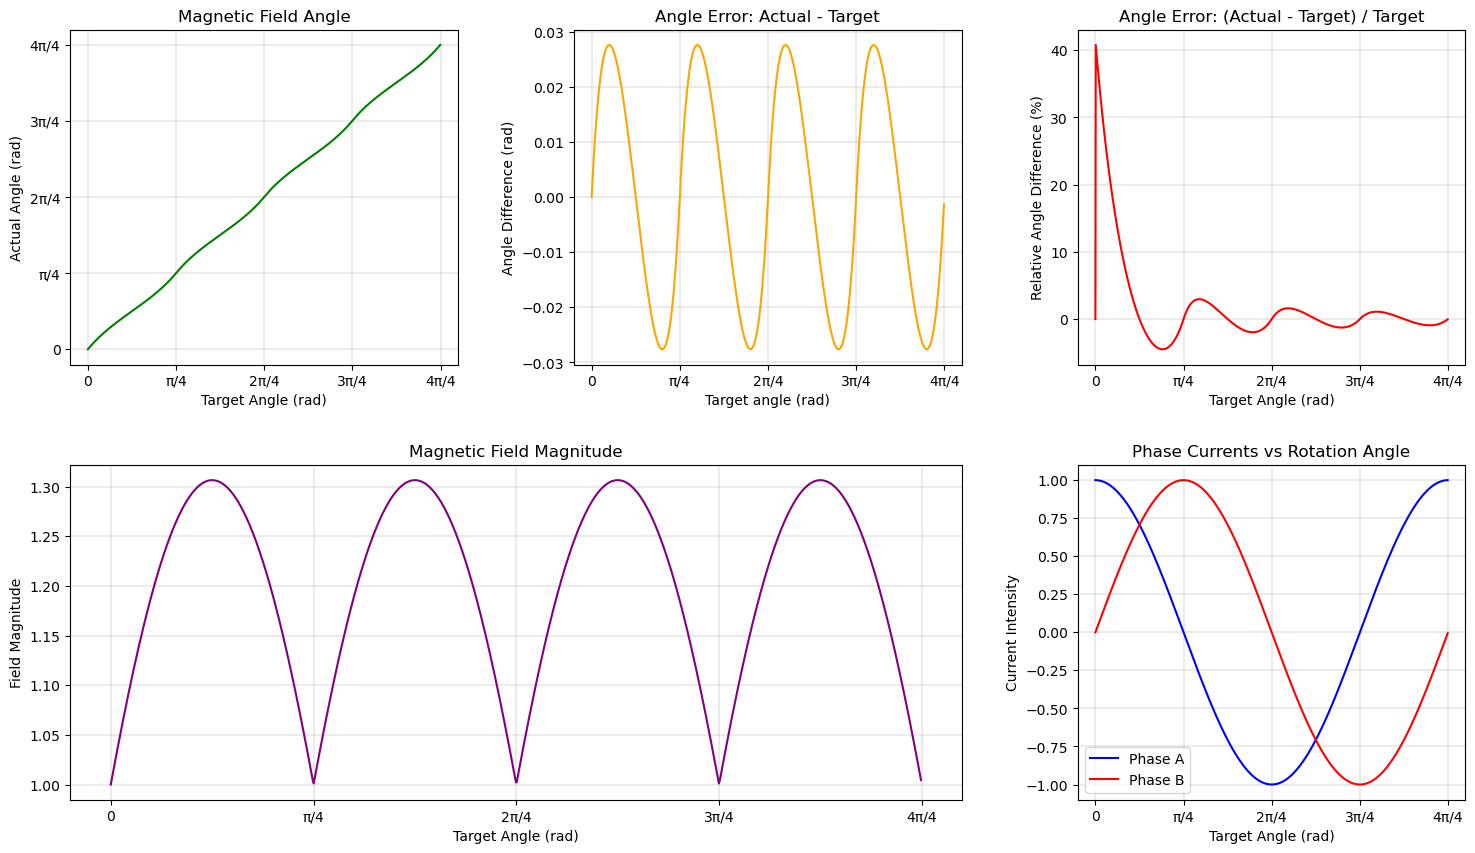

In [4]:
# Plot results
control = standard_control

thetas = np.linspace(0, np.pi, 1000)[:-1]
IAs = [control(t)[0] for t in thetas]
IBs = [control(t)[1] for t in thetas]
magnitudes = [calculate_magnetic_field(*I)[0] for I in zip(IAs, IBs)]
angles = [calculate_magnetic_field(*I)[1] for I in zip(IAs, IBs)]
angle_difference = [angle - theta for angle, theta in zip(angles, thetas)]
relative_angle_difference = [(angle - theta) / theta * 100 if theta != 0 else 0 for angle, theta in zip(angles, thetas)]

# Create custom tick formatter for angles in terms of π/4
from matplotlib.ticker import FuncFormatter, MultipleLocator

def format_pi_4(value, pos):
    """Format tick labels as multiples of π/4"""
    # Convert to multiples of π/4
    multiple = value / (np.pi / 4)
    
    if abs(multiple) < 1e-10:
        return '0'
    elif abs(multiple - 1) < 1e-10:
        return 'π/4'
    elif abs(multiple + 1) < 1e-10:
        return '-π/4'
    else:
        # Format as fraction of π if it's a nice multiple
        if abs(multiple - round(multiple)) < 1e-10:
            multiple = int(round(multiple))
            if multiple == 1:
                return 'π/4'
            elif multiple == -1:
                return '-π/4'
            else:
                return f'{multiple}π/4'
        else:
            return f'{multiple:.2f}π/4'

pi_4_formatter = FuncFormatter(format_pi_4)

# Create 5 graphs in 2 rows: 3 on top, 2 on bottom
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Top row - 3 graphs
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Bottom row - 2 graphs
ax4 = fig.add_subplot(gs[1, 0:2])
ax5 = fig.add_subplot(gs[1, 2])

# Graph 1: Angle of the resulting field
ax1.plot(thetas, angles, color='green')
ax1.set_xlabel('Target Angle (rad)')
ax1.set_ylabel('Actual Angle (rad)')
ax1.set_title('Magnetic Field Angle')
ax1.grid(True, linewidth=0.35)
ax1.xaxis.set_major_formatter(pi_4_formatter)
ax1.xaxis.set_major_locator(MultipleLocator(np.pi/4))
ax1.yaxis.set_major_formatter(pi_4_formatter)
ax1.yaxis.set_major_locator(MultipleLocator(np.pi/4))

# Graph 2: Absolute angle difference
ax2.plot(thetas, angle_difference, color='orange')
ax2.set_xlabel('Target angle (rad)')
ax2.set_ylabel('Angle Difference (rad)')
ax2.set_title ('Angle Error: Actual - Target')
ax2.grid(True, linewidth=0.35)
ax2.xaxis.set_major_formatter(pi_4_formatter)
ax2.xaxis.set_major_locator(MultipleLocator(np.pi/4))

# Graph 3: Relative angle difference (percentage)
ax3.plot(thetas, relative_angle_difference, color='red')
ax3.set_xlabel('Target Angle (rad)')
ax3.set_ylabel('Relative Angle Difference (%)')
ax3.set_title ('Angle Error: (Actual - Target) / Target')
ax3.grid(True, linewidth=0.35)
ax3.xaxis.set_major_formatter(pi_4_formatter)
ax3.xaxis.set_major_locator(MultipleLocator(np.pi/4))

# Graph 4: Magnitude of the resulting field
ax4.plot(thetas, magnitudes, color='purple')
ax4.set_xlabel('Target Angle (rad)')
ax4.set_ylabel('Field Magnitude')
ax4.set_title('Magnetic Field Magnitude')
ax4.grid(True, linewidth=0.35)
ax4.xaxis.set_major_formatter(pi_4_formatter)
ax4.xaxis.set_major_locator(MultipleLocator(np.pi/4))

# Graph 5: IA and IB as a function of theta
ax5.plot(thetas, IAs, label='Phase A', color='blue')
ax5.plot(thetas, IBs, label='Phase B', color='red')
ax5.set_xlabel('Target Angle (rad)')
ax5.set_ylabel('Current Intensity')
ax5.set_title('Phase Currents vs Rotation Angle')
ax5.legend()
ax5.grid(True, linewidth=0.35)
ax5.xaxis.set_major_formatter(pi_4_formatter)
ax5.xaxis.set_major_locator(MultipleLocator(np.pi/4))

plt.show()

In [5]:
from math import isclose
pitch = PI/25
angle = 3 * pitch + 0.0000000001
isclose(angle%pitch, 0, abs_tol=1e-9)

True